<a href="https://colab.research.google.com/github/Abtin-Ghorbani/mastrs_project_XAI_pneumonia_detection/blob/main/masters_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dawnload dataset from Kaggle**

In [1]:
from google.colab import drive
import os
import shutil
import kagglehub
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q Kaggle
from google.colab import files
files.upload()
import os
# فقط در صورت نبود فایل zip، دانلود کن
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print(" Dataset ZIP already exists")
# فقط اگر فولدر chest_xray نیست، unzip کن
if not os.path.exists("dataset/chest_xray"):
    !unzip -q chest-xray-pneumonia.zip -d dataset
else:
    print(" Dataset already extracted")
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#  دانلود فقط اگر فایل ZIP هنوز وجود نداره
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print("Dataset ZIP already exists")

# استخراج فقط اگر فولدر اصلی chest_xray هنوز ساخته نشده
if not os.path.exists("dataset/chest_xray"):
    !unzip -n chest-xray-pneumonia.zip -d dataset
    !rm -rf dataset/__MACOSX  # حذف فایل‌های مزاحم مک
else:
    print("Dataset already extracted")


Streaming output truncated to the last 5000 lines.
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: d

In [3]:
import os

base_dir = '/content/dataset/chest_xray'
print(os.listdir(base_dir))#folder names

['train', 'test', '__MACOSX', 'val', 'chest_xray']


# **task 1 data preproccessing**

In [4]:
import os
import shutil
import random

# مسیر داده‌های اصلی و مسیر ذخیره‌ی داده‌های جدید
base_dir = 'dataset/chest_xray'
new_base = 'dataset/chest_xray_balanced'

# ساخت پوشه‌ی جدید اگه وجود نداره
os.makedirs(new_base, exist_ok=True)


In [5]:
normal_all = []
pneumonia_all = []

for folder in ['train', 'test', 'val']:
    normal_path = os.path.join(base_dir, folder, 'NORMAL')
    pneumonia_path = os.path.join(base_dir, folder, 'PNEUMONIA')

    normal_all += [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    pneumonia_all += [os.path.join(pneumonia_path, f) for f in os.listdir(pneumonia_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]


In [6]:

min_len = min(len(normal_all), len(pneumonia_all))

normal_all = random.sample(normal_all, min_len)
pneumonia_all = random.sample(pneumonia_all, min_len)

print(f"After balancing: {len(normal_all)} NORMAL and {len(pneumonia_all)} PNEUMONIA")


After balancing: 1583 NORMAL and 1583 PNEUMONIA


In [7]:
def split_data(file_list, train_ratio=0.7, val_ratio=0.2):
    random.shuffle(file_list)
    total = len(file_list)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    return file_list[:train_end], file_list[train_end:val_end], file_list[val_end:]

normal_train, normal_val, normal_test = split_data(normal_all)
pneumonia_train, pneumonia_val, pneumonia_test = split_data(pneumonia_all)


In [8]:
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# مسیرهای خروجی نهایی
for label, train, val, test in zip(
    ['NORMAL', 'PNEUMONIA'],
    [normal_train, pneumonia_train],
    [normal_val, pneumonia_val],
    [normal_test, pneumonia_test]
):
    copy_files(train, os.path.join(new_base, 'train', label))
    copy_files(val, os.path.join(new_base, 'val', label))
    copy_files(test, os.path.join(new_base, 'test', label))


In [9]:
for split in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_base, split, label)
        print(f"{split.upper()} - {label}: {len(os.listdir(folder))} images")


TRAIN - NORMAL: 1108 images
TRAIN - PNEUMONIA: 1108 images
VAL - NORMAL: 316 images
VAL - PNEUMONIA: 316 images
TEST - NORMAL: 159 images
TEST - PNEUMONIA: 159 images


In [10]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32
base_dir = 'dataset/chest_xray_balanced'

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'val'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'test'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 2216 files belonging to 2 classes.
Found 632 files belonging to 2 classes.
Found 318 files belonging to 2 classes.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for images, labels in train_ds.take(1):  # فقط یک batch می‌گیریم
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())  # چاپ لیبل‌های واقعی

Images shape: (32, 224, 224, 3)
Labels shape: (32, 1)
Labels: [[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


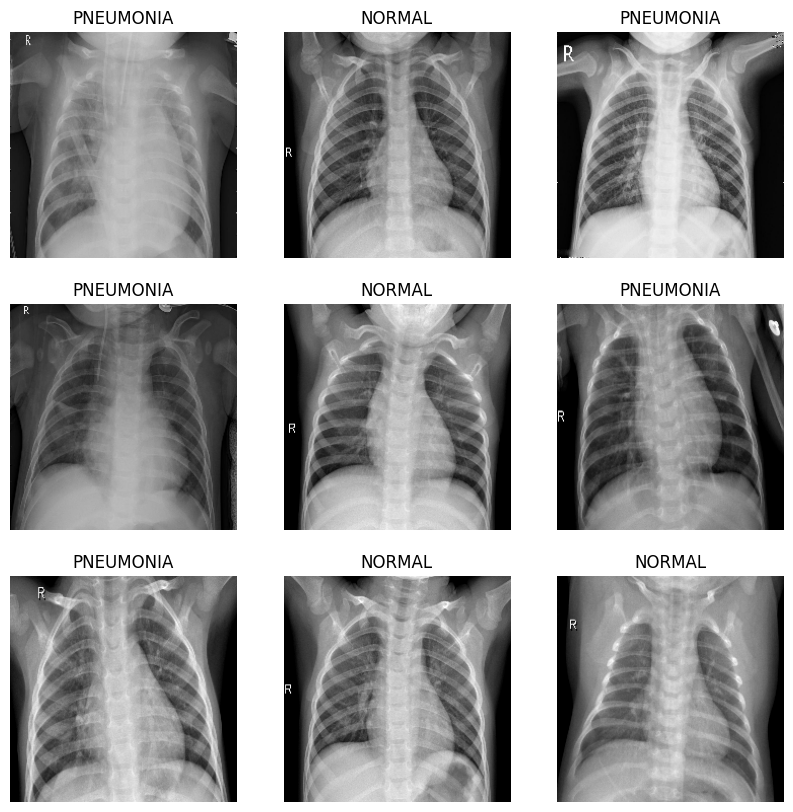

In [ ]:
import matplotlib.pyplot as plt

class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# **Normalization**

In [ ]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
def preprocess(image, label):
    image = preprocess_input(image)  # between mobile net [-1, 1]
    return image, label
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# **buld and Train CNN model for pneumonia classification**

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # فریز کردن وزن‌های مدل

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **buil model **

In [ ]:
from tensorflow.keras import layers, Model, Input
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_mobilenet_func = Model(inputs=inputs, outputs=outputs, name="mobilenetv2_functional")

# **compile the model **

In [ ]:
# Compile the model with optimizer, loss, and metric
model_mobilenet_func.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',                                # For binary classification
    metrics=['accuracy']
)

In [ ]:
model_mobilenet_func.summary()

Model: "mobilenetv2_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

2222# # **train model with images**

In [ ]:
# Train the model using early stopping
history = model_mobilenet_func.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        # tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy: 0.4804 - loss: 0.7703 - val_accuracy: 0.6566 - val_loss: 0.6185
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6355 - loss: 0.6262 - val_accuracy: 0.8085 - val_loss: 0.5129
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7707 - loss: 0.5125 - val_accuracy: 0.8671 - val_loss: 0.4364
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8383 - loss: 0.4417 - val_accuracy: 0.9035 - val_loss: 0.3834
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8582 - loss: 0.4034 - val_accuracy: 0.9035 - val_loss: 0.3437
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8827 - loss: 0.3651 - val_accuracy: 0.9130 - val_loss: 0.3150
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9028 - loss: 0.3253 - val_accuracy: 0.9256 - val_loss: 0.2940
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9005 - loss: 0.3132 - val_accuracy: 0.9193 -

In [ ]:
model_mobilenet_func.save("/content/mobilenetv2_functional_trained.keras")

In [ ]:
model_mobilenet_func.save("/content/drive/MyDrive/mobilenetv2_functional_trained.keras")

In [ ]:
model_mobilenet_func.save("/content/drive/MyDrive/masters project/mobilenetv2_functional_trained.keras")

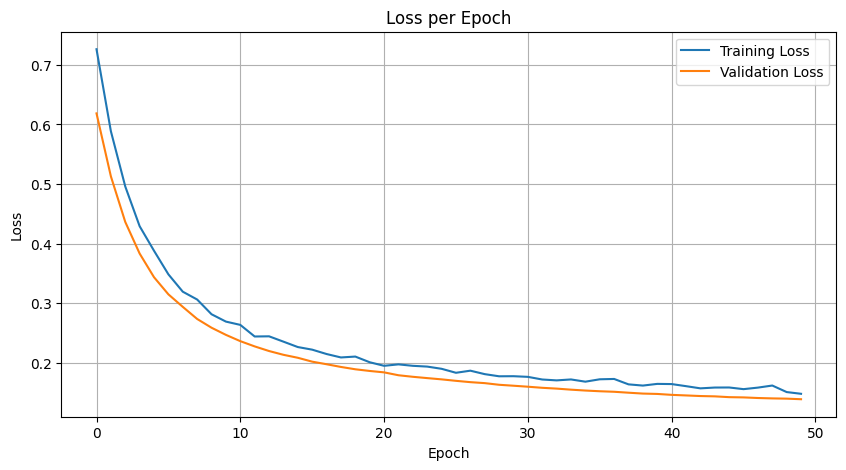

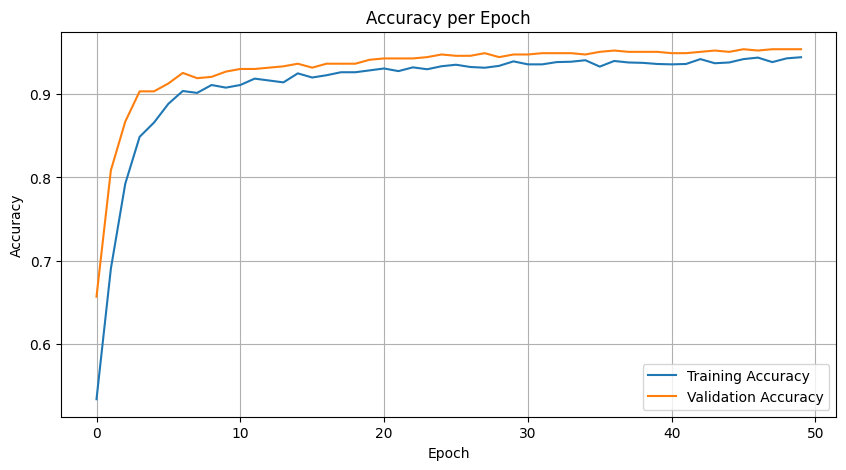

In [ ]:
# prompt: write a code to show loss / epoch

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

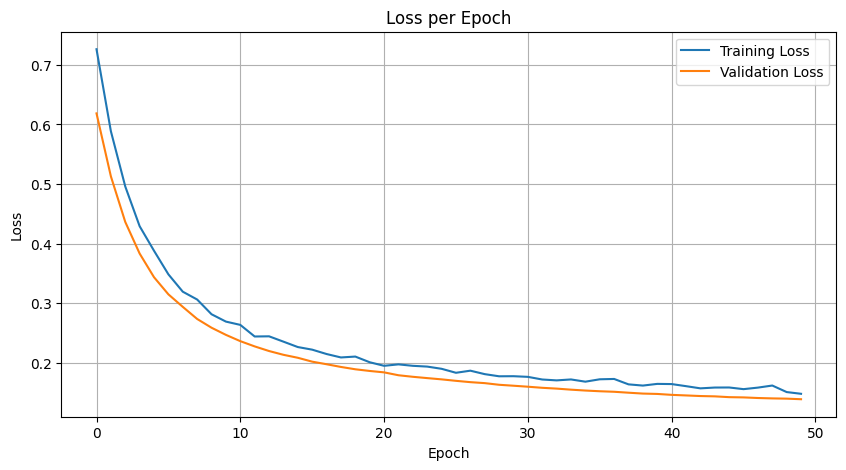

In [ ]:
# prompt: write a code to visualize trainig and validation loss chart
import matplotlib.pyplot as plt

# Assuming `history` object from model training is available
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**save model tranfer learning**

In [ ]:
#model_mobilenet.save("mobilenetv2_transfer_only_final.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
0.9718696


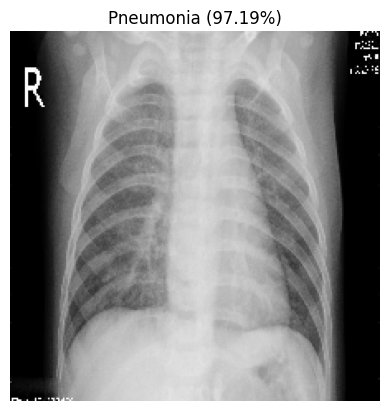

[[0.9718696]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load model
model = model_mobilenet_func
# Load and preprocess image
img_path = '/content/dataset/chest_xray_balanced/test/PNEUMONIA/person77_bacteria_374.jpeg'  # Update path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
prediction = model.predict(img_array)
print(prediction[0][0])
result = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"
confidence = prediction[0][0] if result == "Pneumonia" else 1 - prediction[0][0]

# Display
plt.imshow(img)
plt.title(f"{result} ({confidence:.2%})")
plt.axis('off')
plt.show()
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0.0034249346


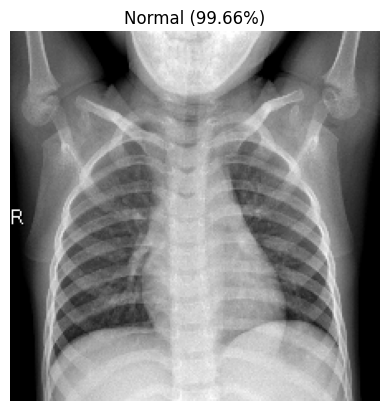

[[0.00342493]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load model
model = model_mobilenet_func
# Load and preprocess image
img_path = '/content/dataset/chest_xray_balanced/test/NORMAL/NORMAL2-IM-1090-0001.jpeg'  # Update path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
prediction = model.predict(img_array)
print(prediction[0][0])
result = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"
confidence = prediction[0][0] if result == "Pneumonia" else 1 - prediction[0][0]

# Display
plt.imshow(img)
plt.title(f"{result} ({confidence:.2%})")
plt.axis('off')
plt.show()
print(prediction)

# **evaluate model**

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_mobilenet_func.evaluate(test_ds)
print(f"Test Accuracy for mobile net: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 840ms/step - accuracy: 0.9273 - loss: 0.1769
Test Accuracy for mobile net: 0.9371


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: predicts and labels
y_true_befor = []
y_pred_befor = []
for images, labels in test_ds:
    preds_befor = model_mobilenet_func.predict(images)
    preds_befor = (preds_befor > 0.6).astype("int32")  # آستانه‌ی sigmoid
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds_befor)

# Step 2 evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_true_befor, y_pred_befor))

print("\nClassification Report for transfer learning:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
[[153   6]
 [ 15 144]]

Classification Report for transfer learning:
              precision    recall  f1-score   support

      NORMAL       0.91      0.96      0.94       159
   PNEUMONIA       0.96      0.91      0.93       159

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.94      0.93      0.93       318



In [ ]:
# prompt: write a code to save this model_mobilenet tu goggle drive in this folder /content/drive/MyDrive/masters project

#model_save_path = '/content/drive/MyDrive/masters project/mobilenet_balanced_model3.keras'
#model_mobilenet.save(model_save_path)
#print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/masters project/mobilenet_balanced_model3.keras


In [ ]:
from tensorflow.keras.models import load_model
#model_mobilenet_3 = load_model("/content/drive/MyDrive/masters project/mobilenet_balanced_model3.keras")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: predicts and labels
y_true_befor = []
y_pred_befor = []
for images, labels in test_ds:
    preds_befor = model_mobilenet_func.predict(images)
    preds_befor = (preds_befor > 0.6).astype("int32")  # آستانه‌ی sigmoid
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds_befor)

# Step 2 evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_true_befor, y_pred_befor))

print("\nClassification Report for transfer learning:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Confusion Matrix:
[[288  16]
 [ 16 298]]

Classification Report for transfer learning:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       304
   PNEUMONIA       0.95      0.95      0.95 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


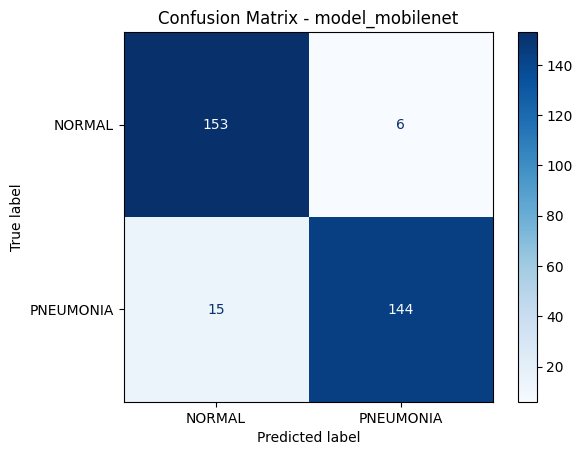


Classification Report for model_mobilenet:
              precision    recall  f1-score   support

      NORMAL       0.91      0.96      0.94       159
   PNEUMONIA       0.96      0.91      0.93       159

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.94      0.93      0.93       318



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Baraye ROC va PR curve ehtiyaj be prob ha darim pas az now sabt mikonim
y_true_befor = []
y_pred_befor = []
y_pred_probs_befor = []

for images, labels in test_ds:
    probs = model_mobilenet_func.predict(images)  # sigmoid output
    preds = (probs > 0.6).astype("int32")  # threshold 0.6
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds)
    y_pred_probs_befor.extend(probs[:, 0])  # flatten

# Confusion Matrix
cm = confusion_matrix(y_true_befor, y_pred_befor)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - model_mobilenet")
plt.grid(False)
plt.show()

# Classification Report
print("\nClassification Report for model_mobilenet:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


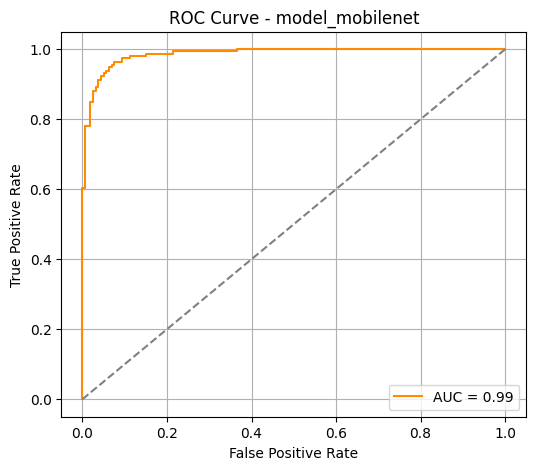

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_befor, y_pred_probs_befor)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - model_mobilenet')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
model_mobilenet_func.save(r"/content/drive/MyDrive/masters project/mobilenetv2_functional_trained.keras")

# **feature wxtraction for ML**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tqdm import tqdm

In [ ]:
from tensorflow.keras.models import Model
# گرفتن input از مدل و خروجی درست از لایه GAP
input_tensor = model_mobilenet_func.input
output_tensor = model_mobilenet_func.get_layer("global_avg_pool").output
# ساخت feature extractor
feature_extractor = Model(inputs=input_tensor, outputs=output_tensor)
feature_extractor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import numpy as np
from tqdm import tqdm

def extract_features_and_labels(dataset):
    features = []
    labels = []
    for images, label_batch in tqdm(dataset, desc="Extracting Features"):
        batch_features = feature_extractor.predict(images, verbose=0)
        features.extend(batch_features)
        labels.extend(label_batch.numpy())
    return np.array(features), np.array(labels)
# اجرا روی train / val / test
train_features, train_labels = extract_features_and_labels(train_ds)
val_features, val_labels = extract_features_and_labels(val_ds)
test_features, test_labels = extract_features_and_labels(test_ds)


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


In [ ]:
# ساخت نام ویژگی‌ها (1280 تا)
feature_names = [f"feature_{i+1}" for i in range(train_features.shape[1])]
# ذخیره همه‌چیز در فایل فشرده
np.savez_compressed("/content/drive/MyDrive/cnn_features_balanced_named.npz",
                    train_X=train_features, train_y=train_labels,
                    val_X=val_features, val_y=val_labels,
                    test_X=test_features, test_y=test_labels,
                    feature_names=feature_names)
print("Feature extraction completed and saved")

Feature extraction completed and saved!


In [ ]:
import numpy as np

data = np.load("/content/drive/MyDrive/cnn_features_balanced_named.npz")
train_X = data["train_X"]
train_y = data["train_y"]
feature_names = data["feature_names"]  # ['feature_1', 'feature_2', ..., 'feature_1280']

In [ ]:
import pandas as pd
# اولین نمونه (مثلاً تصویر اول)
sample_index = 0
sample_features = train_X[sample_index]
# نمایش به صورت جدول با نام فیچرها
df = pd.DataFrame([sample_features], columns=feature_names)
df.T.head(20)  # فقط 20 ویژگی اول

,0
feature_1,0.213764
feature_2,0.000000
feature_3,0.161292
feature_4,1.235999
feature_5,1.096056
feature_6,0.014031
feature_7,0.211297
feature_8,0.060081
feature_9,0.116840
feature_10,0.035404


In [ ]:
# Create a DataFrame for plotting
df = pd.DataFrame({
    "feature": feature_names,
    "value": sample_features
})

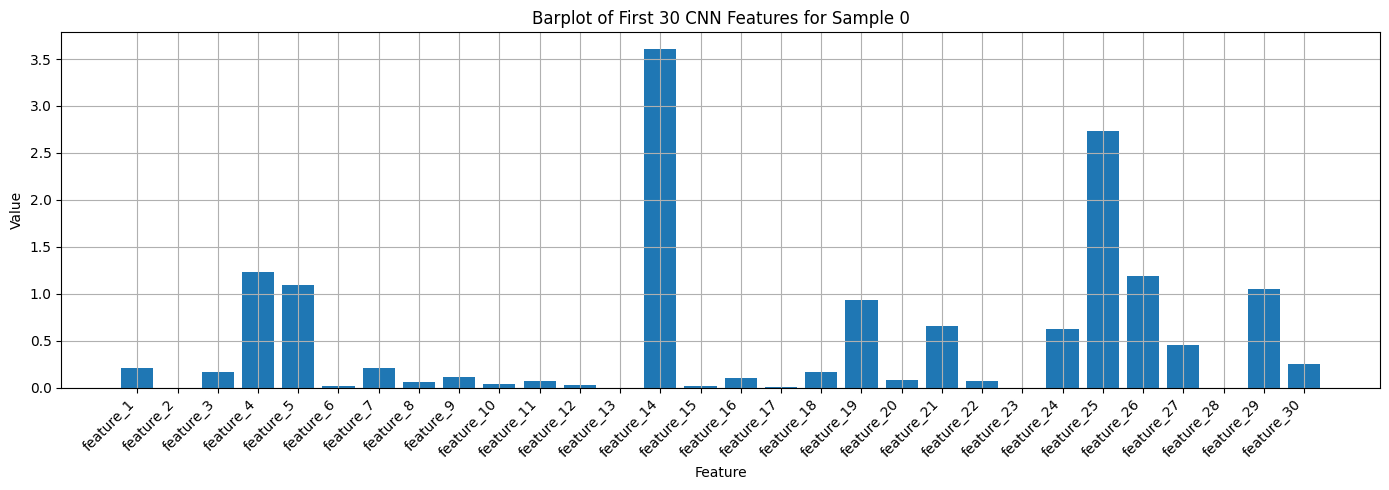

In [ ]:
# Plot bar chart for first 30 features
plt.figure(figsize=(14, 5))
plt.bar(df["feature"][:30], df["value"][:30])
plt.xticks(rotation=45, ha='right')
plt.title("Barplot of First 30 CNN Features for Sample 0")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
data = np.load("/content/drive/MyDrive/cnn_features_balanced_named.npz")
train_X = data['train_X']
train_y = data['train_y']
val_X = data['val_X']
val_y = data['val_y']
test_X = data['test_X']
test_y = data['test_y']
feature_names = data['feature_names']

# **start ML with XGboot**

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#buld model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#train
xgb_model.fit(train_X, train_y)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## **evaluate XGBOOT**

In [ ]:
#  predict val
val_preds = xgb_model.predict(val_X)

In [ ]:
val_acc_XGBOOT = accuracy_score(val_y, val_preds)
print(f" Validation Accuracy XGBOOT: {val_acc_XGBOOT:.4f}")

✅ Validation Accuracy XGBOOT: 0.9525


In [ ]:
test_preds_XGBOOT = xgb_model.predict(test_X)
test_acc_XGBOOT = accuracy_score(test_y, test_preds_XGBOOT)
print(f" Test Accuracy XGBOOt : {test_acc_XGBOOT:.4f}")

 Test Accuracy XGBOOt : 0.9434


In [ ]:
# گزارش کامل
print("\nClassification Report:")
print(classification_report(test_y, test_preds_XGBOOT))

print("\nConfusion Matrix:")
print(confusion_matrix(test_y, test_preds_XGBOOT))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       159
         1.0       0.95      0.93      0.94       159

    accuracy                           0.94       318
   macro avg       0.94      0.94      0.94       318
weighted avg       0.94      0.94      0.94       318


Confusion Matrix:
[[152   7]
 [ 11 148]]


In [ ]:
import joblib
model_path = "/content/drive/MyDrive/masters project/xgb_model_from_cnn_features.pkl"
#model
joblib.dump(xgb_model, model_path)

print("XGboot saved in drived successfully")

XGboot saved in drived successfully


# **XGBOOT classifeir for a specific image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


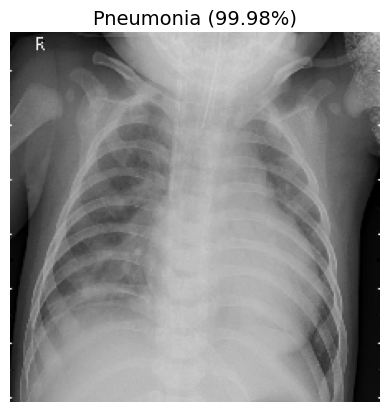

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import joblib

# Load CNN feature extractor model
model_cnn = load_model("/content/drive/MyDrive/masters project/mobilenetv2_functional_trained.keras")
feature_extractor = tf.keras.Model(
    inputs=model_cnn.input,
    outputs=model_cnn.get_layer("global_avg_pool").output
)
# Load XGBoost model
xgb_model = joblib.load("/content/drive/MyDrive/masters project/xgb_model_from_cnn_features.pkl")
# Load and preprocess image
img_path = '/content/dataset/chest_xray_balanced/test/PNEUMONIA/person77_bacteria_374.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
# Extract features and predict
features = feature_extractor.predict(img_array)
prediction = xgb_model.predict(features)[0]
proba = xgb_model.predict_proba(features)[0][prediction]
# Show image and prediction
result = "Pneumonia" if prediction == 1 else "Normal"
confidence = proba

plt.imshow(img)
plt.axis('off')
plt.title(f"{result} ({confidence:.2%})", fontsize=14)
plt.show()

# **shap**

In [ ]:
import shap
import xgboost
import pickle
import matplotlib.pyplot as plt
import numpy as np

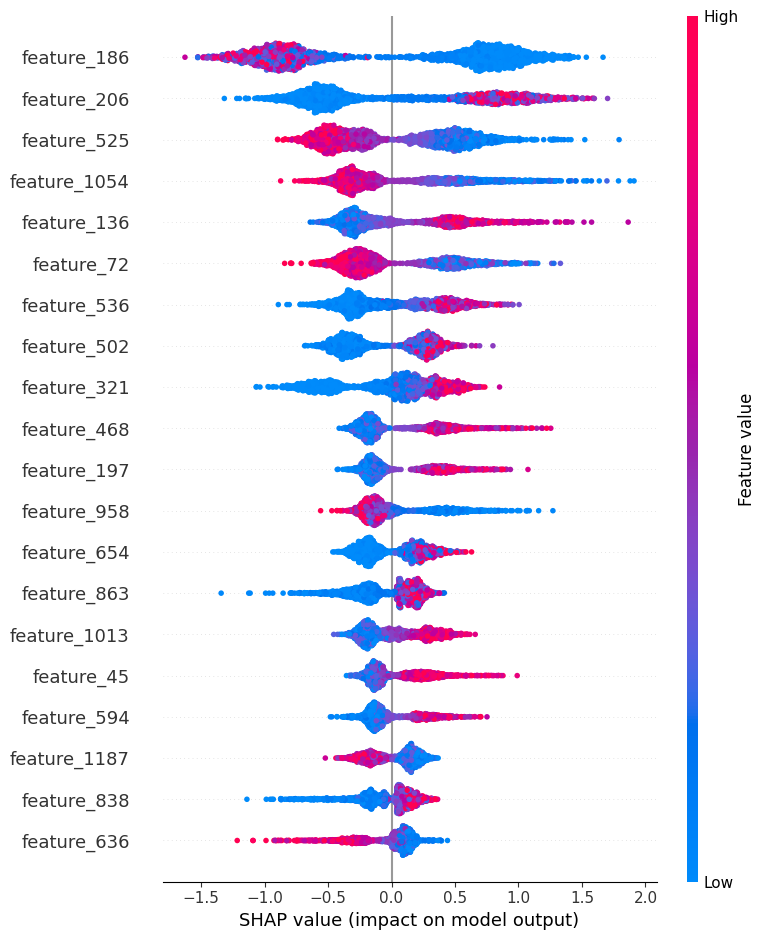

In [ ]:
# Reload the saved XGBoost model
with open("/content/drive/MyDrive/masters project/xgb_model_from_cnn_features.pkl", "rb") as file:
    xgb_model = pickle.load(file)

# Load feature data again
data = np.load("/content/drive/MyDrive/cnn_features_balanced_named.npz")
train_X = data["train_X"]
feature_names = data["feature_names"]
# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(train_X)
# SHAP summary plot
shap.summary_plot(shap_values, train_X, feature_names=feature_names, show=True)


In [ ]:
# نمایش force plot برای اولین نمونه
shap.initjs()  # برای فعال‌سازی نمایش تعاملی

shap.force_plot(
    explainer.expected_value,  # مقدار مورد انتظار مدل
    shap_values[0],            # مقدار shap برای اولین نمونه
    train_X[0],                # ویژگی‌های اولین نمونه
    feature_names=feature_names
)

# **shap for specific image for XGBOOt**

In [ ]:
import shap

# Create explainer and compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(features)

# Display SHAP values (force_plot or waterfall)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=features,
    feature_names=[f"feature_{i+1}" for i in range(features.shape[1])]
)


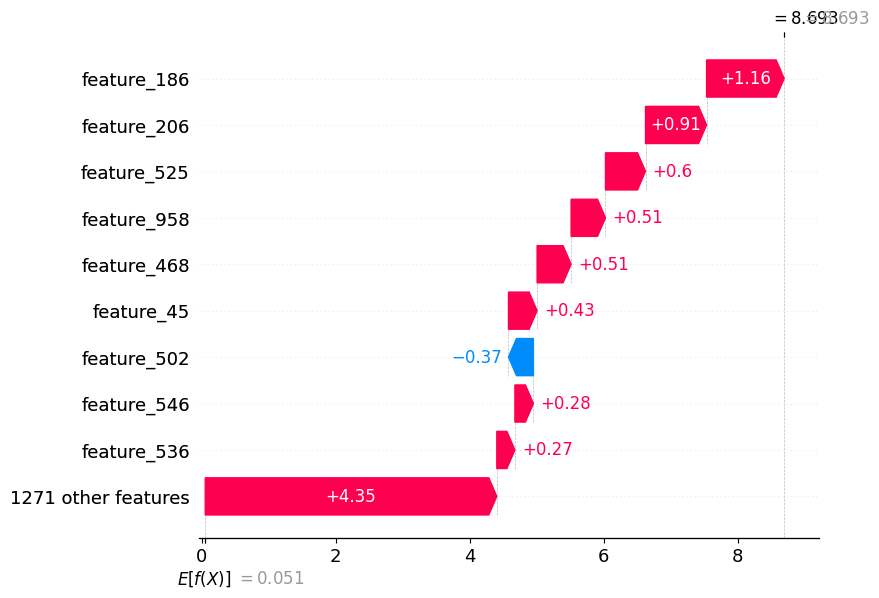

In [ ]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
    feature_names=[f"feature_{i+1}" for i in range(features.shape[1])]
)

# **heatmaps with CNN output**

# **Grad_cam**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# بارگذاری مدل آموزش‌دیده CNN
#model_mobilenet_func = load_model("/content/drive/MyDrive/masters project/mobilenetv2_functional_trained.keras")


In [ ]:
# prompt: which version of tensflow im using

tf.__version__

'2.18.0'

In [ ]:
# بررسی لایه‌های موبایل‌نت داخل مدل Functional
base_model = model_mobilenet_func.get_layer('mobilenetv2_1.00_224')
for i, layer in enumerate(base_model.layers[::-1]):
    print(i, layer.name)
    if 'Conv_1' in layer.name:
        break

0 out_relu
1 Conv_1_bn


In [ ]:
# نمایش همه‌ی لایه‌ها از انتها برای پیدا کردن Conv_1
base_model = model_mobilenet_func.get_layer('mobilenetv2_1.00_224')
for i, layer in enumerate(base_model.layers[::-1]):
    print(i, layer.name)

0 out_relu
1 Conv_1_bn
2 Conv_1
3 block_16_project_BN
4 block_16_project
5 block_16_depthwise_relu
6 block_16_depthwise_BN
7 block_16_depthwise
8 block_16_expand_relu
9 block_16_expand_BN
10 block_16_expand
11 block_15_add
12 block_15_project_BN
13 block_15_project
14 block_15_depthwise_relu
15 block_15_depthwise_BN
16 block_15_depthwise
17 block_15_expand_relu
18 block_15_expand_BN
19 block_15_expand
20 block_14_add
21 block_14_project_BN
22 block_14_project
23 block_14_depthwise_relu
24 block_14_depthwise_BN
25 block_14_depthwise
26 block_14_expand_relu
27 block_14_expand_BN
28 block_14_expand
29 block_13_project_BN
30 block_13_project
31 block_13_depthwise_relu
32 block_13_depthwise_BN
33 block_13_depthwise
34 block_13_pad
35 block_13_expand_relu
36 block_13_expand_BN
37 block_13_expand
38 block_12_add
39 block_12_project_BN
40 block_12_project
41 block_12_depthwise_relu
42 block_12_depthwise_BN
43 block_12_depthwise
44 block_12_expand_relu
45 block_12_expand_BN
46 block_12_expand
4

In [ ]:
model_mobilenet_func.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer_1>

# **load pneumonia image and preprocess it**

In [ ]:
# Set path to your image
img_path = '/content/dataset/chest_xray_balanced/test/PNEUMONIA/person371_bacteria_1701.jpeg'



predict image with CNN model

In [ ]:
# Predict class
preds = model_mobilenet_func.predict(img_preprocessed)
class_idx = int(preds[0][0] > 0.5)
class_label = "Pneumonia" if class_idx == 1 else "Normal"
confidence = preds[0][0] if class_label == "Pneumonia" else 1 - preds[0][0]

print(f"Prediction: {class_label} ({confidence:.2%})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Pneumonia (99.78%)


**build Grad cam**

In [ ]:
model_mobilenet_func.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer_1>

In [ ]:
print(img_preprocessed.shape)

(1, 224, 224, 3)


In [13]:
from tensorflow.keras.models import load_model

model_mobilenet_func = load_model("/content/drive/MyDrive/masters project/mobilenetv2_functional_trained.keras")

In [23]:
# گرفتن لایه کانولوشنی نهایی از خود base_model
last_conv_layer = base_model.get_layer("Conv_1")  # NOT model_mobilenet_func

# ساخت grad_model فقط از base_model (نه مدل کامل)
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[last_conv_layer.output, base_model.output]
)

In [24]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load image
img_path = '/content/dataset/chest_xray_balanced/test/PNEUMONIA/person38_bacteria_190.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_tensor = preprocess_input(img_array)  # Shape: (1, 224, 224, 3)


In [26]:
# پیش‌بینی نهایی با مدل کامل
pred = model_mobilenet_func.predict(img_tensor, verbose=0)[0][0]
class_label = "Pneumonia" if pred >= 0.5 else "Normal"
confidence = pred if class_label == "Pneumonia" else 1 - pred
print(f"Prediction: {class_label} ({confidence:.2%} confidence)")

Prediction: Pneumonia (99.45% confidence)


In [27]:
import tensorflow as tf

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor)
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
heatmap = heatmap.numpy()

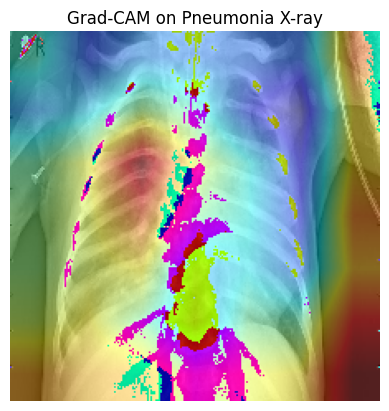

In [28]:
# رسم روی تصویر اصلی
heatmap = cv2.resize(heatmap, (224, 224))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + img  # ترکیب با تصویر RGB اصلی

# نمایش
plt.imshow(np.uint8(superimposed_img))
plt.axis("off")
plt.title("Grad-CAM on Pneumonia X-ray")
plt.show()

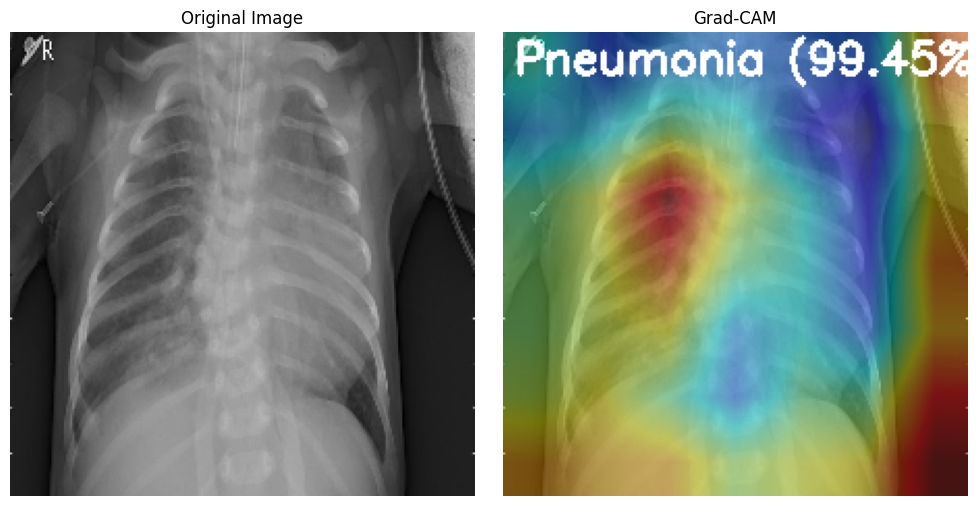

In [29]:
import matplotlib.pyplot as plt
import cv2

# بازخوانی تصویر اصلی برای نمایش
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (224, 224))

# تغییر اندازه heatmap برای انطباق با تصویر
heatmap_resized = cv2.resize(heatmap, (224, 224))

# تبدیل heatmap به RGB رنگی
heatmap_rgb = np.uint8(255 * heatmap_resized)
heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)

# ترکیب heatmap با تصویر اصلی
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_rgb, 0.4, 0)

# اضافه کردن label به تصویر
label_text = f"{class_label} ({confidence:.2%})"
cv2.putText(superimposed_img, label_text, (5, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# نمایش کنار هم: تصویر اصلی و heatmap
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
pip install tf-explain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
from tf_explain.core.grad_cam import GradCAM

In [ ]:
# Load pretrained model or your own
model = model_mobilenet_func
# Load a sample image (or multiple ones)
IMAGE_PATH = '/content/dataset/chest_xray_balanced/test/PNEUMONIA/person1320_bacteria_3352.jpeg'

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=281)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

AttributeError: 'Dense' object has no attribute 'output_shape'